# Evaluation of text similarity metrics using GLUE tasks

This notebook contains the evaluation code we used for the paper, i.e., an STSScorer that is based on RoBERTa. 

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import transformers

from bert_score import BERTScorer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
from datasets import load_dataset
from transformers import logging
logging.set_verbosity_error()


class STSScorer:
    def __init__(self):
        model_name = 'WillHeld/roberta-base-stsb'
        self._sts_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
        self._sts_model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)
        self._sts_model.eval()

    def score(self, sentence1, sentence2):
        sts_tokenizer_output = self._sts_tokenizer(sentence1, sentence2, padding=True, truncation=True, return_tensors="pt")
        sts_model_output = self._sts_model(**sts_tokenizer_output)
        return sts_model_output['logits'].item()/5
    
class SBERTCosine:
    def __init__(self):
        model_name = 'sentence-transformers/all-MiniLM-L6-v2'
        self._sbert_model = SentenceTransformer(model_name)
        self._sbert_model.eval()

    def score(self, sentence1, sentence2):
        embeddings = self._sbert_model.encode([sentence1, sentence2])
        return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

bertscorer = BERTScorer(lang="en", rescale_with_baseline=True)
bleu = evaluate.load("bleu")
sts_scorer = STSScorer()
sbertcosine = SBERTCosine()

def fetch_scores(data, feature1, feature2):
    print('Number of instances:',len(data))
    scores = []
    count = 0
    
    # check if data is pd.DataFrame
    if isinstance(data, pd.DataFrame):
        for index, row in data.iterrows():
            scores.append(score_instance(row, feature1, feature2))
            count += 1
            if count % (int(len(data)/10)) == 0:
                print('%i done (%i%%)' % (count, count/len(data)*100))
    else:    
        for instance in data:
            scores.append(score_instance(instance, feature1, feature2))
            count += 1
            if count % (int(len(data)/10)) == 0:
                print('%i done (%i%%)' % (count, count/len(data)*100))
    return scores

def score_instance(instance, feature1, feature2):
    bert_score = bertscorer.score([instance[feature1]], [instance[feature2]], verbose=False)
    bleu_score = bleu.compute(predictions=[instance[feature1]], references=[instance[feature2]])['bleu']
    stsb_score = sts_scorer.score(instance[feature1], instance[feature2])
    sbert_score = sbertcosine.score(instance[feature1], instance[feature2])
    return {'label': instance['label'], 'bertscore_precision': bert_score[0].item(), 'bertscore_recall': bert_score[1].item(), 'bertscore_f1': bert_score[2].item(), 'bleu': bleu_score, 'sts_score': stsb_score, 'sbertcosine': sbert_score}

/home/sherbold/git/stsscore/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## STS-B

In [2]:
data = load_dataset("stsb_multi_mt", name="en", split="test")
data = data.rename_column("similarity_score", "label")
scores_stsb = pd.DataFrame(fetch_scores(data, 'sentence1', 'sentence2'))

scores_stsb.to_csv('scores/stsb.csv')

Number of instances: 1379
137 done (9%)
274 done (19%)
411 done (29%)
548 done (39%)
685 done (49%)
822 done (59%)
959 done (69%)
1096 done (79%)
1233 done (89%)
1370 done (99%)


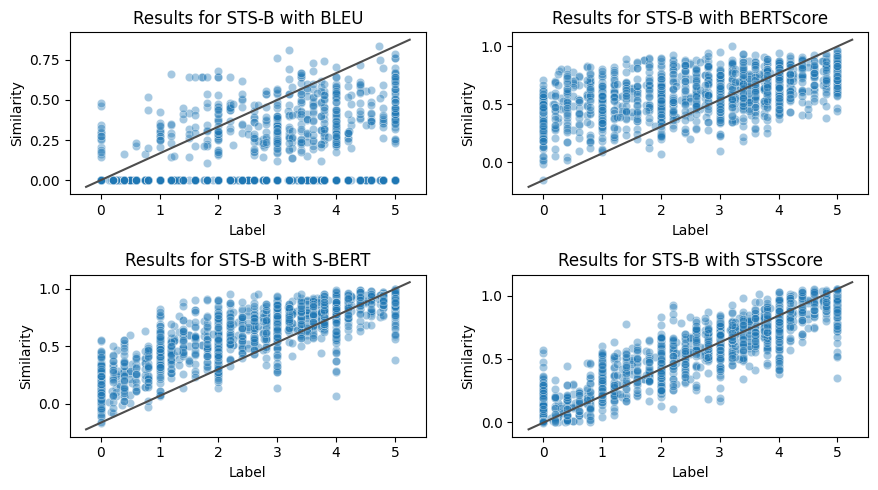

Pearson correlation


bleu            0.337758
bertscore_f1    0.528701
sts_score       0.895954
sbertcosine     0.827406
Name: label, dtype: float64

Spearman correlation


bleu            0.322598
bertscore_f1    0.527129
sts_score       0.889743
sbertcosine     0.820325
Name: label, dtype: float64

In [3]:
scores_stsb = pd.read_csv('scores/stsb.csv')

def draw_diagonal(ax):
    ax.plot(ax.get_xlim(), ax.get_ylim(), c=".3")

fig, axes = plt.subplots(2, 2, figsize=(9, 5))
sns.scatterplot(x="label", y="bleu", data=scores_stsb, alpha=0.4, ax=axes[0,0])
sns.scatterplot(x="label", y="bertscore_f1", data=scores_stsb, alpha=0.4, ax=axes[0,1])
sns.scatterplot(x="label", y="sbertcosine", data=scores_stsb, alpha=0.4, ax=axes[1,0])
sns.scatterplot(x="label", y="sts_score", data=scores_stsb, alpha=0.4, ax=axes[1,1])
draw_diagonal(axes[0,0])
draw_diagonal(axes[0,1])
draw_diagonal(axes[1,0])
draw_diagonal(axes[1,1])
axes[0,0].set_ylabel("Similarity")
axes[0,1].set_ylabel("Similarity")
axes[1,0].set_ylabel("Similarity")
axes[1,1].set_ylabel("Similarity")
axes[0,0].set_xlabel("Label")
axes[0,1].set_xlabel("Label")
axes[1,0].set_xlabel("Label")
axes[1,1].set_xlabel("Label")
axes[0,0].set_title("Results for STS-B with BLEU")
axes[0,1].set_title("Results for STS-B with BERTScore")
axes[1,0].set_title("Results for STS-B with S-BERT")
axes[1,1].set_title("Results for STS-B with STSScore")

fig.tight_layout()
plt.savefig('plots/stsb.pdf', bbox_inches='tight')
plt.savefig('plots/stsb.png', bbox_inches='tight')
plt.show()

print('Pearson correlation')
display(scores_stsb.corr(method='pearson')['label'][['bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']])
print('Spearman correlation')
display(scores_stsb.corr(method='spearman')['label'][['bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']])

## MRPC

In [4]:
data = load_dataset('glue', 'mrpc')['test']
scores_mrpc = pd.DataFrame(fetch_scores(data, 'sentence1', 'sentence2'))
scores_mrpc.to_csv('scores/mrpc.csv')

Number of instances: 1725
172 done (9%)
344 done (19%)
516 done (29%)
688 done (39%)
860 done (49%)
1032 done (59%)
1204 done (69%)
1376 done (79%)
1548 done (89%)
1720 done (99%)


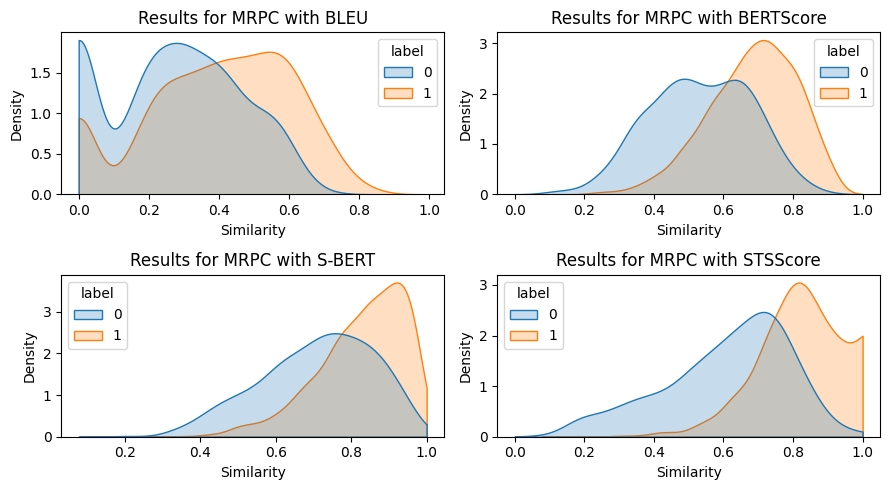

Mean


,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score,sbertcosine
label,,,,,,,
0,887.468858,0.535354,0.530233,0.532616,0.260324,0.610237,0.709273
1,849.165650,0.684321,0.682521,0.683187,0.392253,0.837354,0.827843


Standard deviation


,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score,sbertcosine
label,,,,,,,
0,505.174105,0.159769,0.164882,0.145341,0.191747,0.180008,0.149024
1,494.234810,0.142888,0.139676,0.125755,0.209861,0.134796,0.115480


In [5]:
scores_mrpc = pd.read_csv('scores/mrpc.csv')
fig, axes = plt.subplots(2, 2, figsize=(9, 5))
sns.kdeplot(scores_mrpc, x="bleu", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,0])
sns.kdeplot(scores_mrpc, x="bertscore_f1", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,1])
sns.kdeplot(scores_mrpc, x="sbertcosine", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,0])
sns.kdeplot(scores_mrpc, x="sts_score", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,1])

axes[0,0].set_xlabel("Similarity")
axes[0,1].set_xlabel("Similarity")
axes[1,0].set_xlabel("Similarity")
axes[1,1].set_xlabel("Similarity")
axes[0,0].set_title("Results for MRPC with BLEU")
axes[0,1].set_title("Results for MRPC with BERTScore")
axes[1,0].set_title("Results for MRPC with S-BERT")
axes[1,1].set_title("Results for MRPC with STSScore")

sns.move_legend(axes[1,0], "upper left")
sns.move_legend(axes[1,1], "upper left")
fig.tight_layout()
plt.savefig('plots/mrpc.pdf', bbox_inches='tight')
plt.show()
print('Mean')
display(scores_mrpc.groupby('label').mean())
print('Standard deviation')
display(scores_mrpc.groupby('label').std())

## QQP

In [6]:
data = load_dataset('glue', 'qqp')['train']
scores_qqp = pd.DataFrame(fetch_scores(data, 'question1', 'question2'))
scores_qqp.to_csv('scores/qqp.csv')

Number of instances: 363846
36384 done (9%)
72768 done (19%)
109152 done (29%)
145536 done (39%)
181920 done (49%)
218304 done (59%)
254688 done (69%)
291072 done (79%)
327456 done (89%)
363840 done (99%)


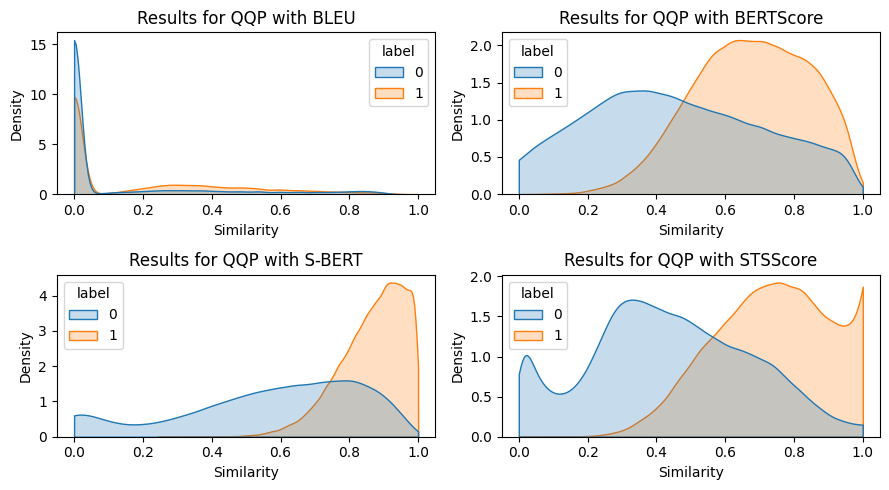

Mean


,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score,sbertcosine
label,,,,,,,
0,182006.746963,0.438191,0.444688,0.441274,0.113036,0.439641,0.560253
1,181778.637299,0.673945,0.673659,0.673431,0.184540,0.762966,0.864571


Standard deviation


,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score,sbertcosine
label,,,,,,,
0,105000.718917,0.275215,0.275584,0.264823,0.232932,0.236197,0.271149
1,105089.519470,0.180303,0.180175,0.166039,0.249377,0.181817,0.095797


In [7]:
scores_qqp = pd.read_csv('scores/qqp.csv')
fig, axes = plt.subplots(2, 2, figsize=(9, 5))
sns.kdeplot(scores_qqp, x="bleu", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,0])
sns.kdeplot(scores_qqp, x="bertscore_f1", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,1])
sns.kdeplot(scores_qqp, x="sbertcosine", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,0])
sns.kdeplot(scores_qqp, x="sts_score", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,1])

axes[0,0].set_xlabel("Similarity")
axes[0,1].set_xlabel("Similarity")
axes[1,0].set_xlabel("Similarity")
axes[1,1].set_xlabel("Similarity")
axes[0,0].set_title("Results for QQP with BLEU")
axes[0,1].set_title("Results for QQP with BERTScore")
axes[1,0].set_title("Results for QQP with S-BERT")
axes[1,1].set_title("Results for QQP with STSScore")

sns.move_legend(axes[0,1], "upper left")
sns.move_legend(axes[1,0], "upper left")
sns.move_legend(axes[1,1], "upper left")
fig.tight_layout()
plt.savefig('plots/qqp.pdf', bbox_inches='tight')
plt.show()

print('Mean')
display(scores_qqp.groupby('label').mean())
print('Standard deviation')
display(scores_qqp.groupby('label').std())

# AUC Analysis for MRPC and QQP

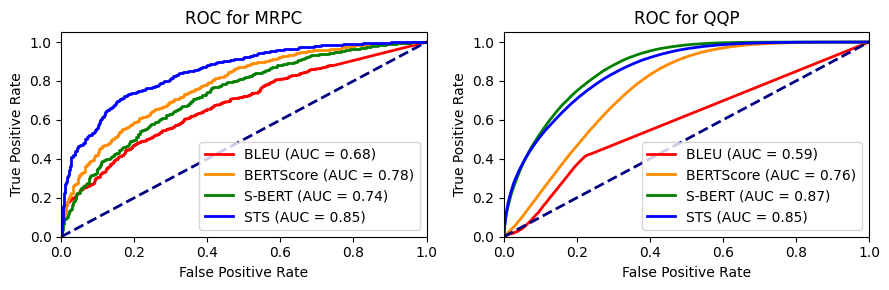

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Plot the ROC curve vor MRPC
# Compute the false positive rate, true positive rate, and thresholds
fpr_bertscore, tpr_bertscore, thresholds_bertscore = roc_curve(scores_mrpc['label'], scores_mrpc['bertscore_f1'])
fpr_bleu, tpr_bleu, thresholds_bleu = roc_curve(scores_mrpc['label'], scores_mrpc['bleu'])
fpr_sbert, tpr_sbert, thresholds_sbert = roc_curve(scores_mrpc['label'], scores_mrpc['sbertcosine'])
fpr_sts, tpr_sts, thresholds_sts = roc_curve(scores_mrpc['label'], scores_mrpc['sts_score'])

# Compute the area under the ROC curve
roc_auc_bertscore = auc(fpr_bertscore, tpr_bertscore)
roc_auc_bleu = auc(fpr_bleu, tpr_bleu)
roc_auc_sbert = auc(fpr_sbert, tpr_sbert)
roc_auc_sts = auc(fpr_sts, tpr_sts)

axes[0].plot(fpr_bleu, tpr_bleu, color='red', lw=2, label='BLEU (AUC = %0.2f)' % roc_auc_bleu)
axes[0].plot(fpr_bertscore, tpr_bertscore, color='darkorange', lw=2, label='BERTScore (AUC = %0.2f)' % roc_auc_bertscore)
axes[0].plot(fpr_sbert, tpr_sbert, color='green', lw=2, label='S-BERT (AUC = %0.2f)' % roc_auc_sbert)
axes[0].plot(fpr_sts, tpr_sts, color='blue', lw=2, label='STS (AUC = %0.2f)' % roc_auc_sts)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC for MRPC')
axes[0].legend(loc="lower right")

# Plot the ROC curve for qqp
# Compute the false positive rate, true positive rate, and thresholds
fpr_bertscore, tpr_bertscore, thresholds_bertscore = roc_curve(scores_qqp['label'], scores_qqp['bertscore_f1'])
fpr_bleu, tpr_bleu, thresholds_bleu = roc_curve(scores_qqp['label'], scores_qqp['bleu'])
fpr_sbert, tpr_sbert, thresholds_sbert = roc_curve(scores_qqp['label'], scores_qqp['sbertcosine'])
fpr_sts, tpr_sts, thresholds_sts = roc_curve(scores_qqp['label'], scores_qqp['sts_score'])

# Compute the area under the ROC curve
roc_auc_bertscore = auc(fpr_bertscore, tpr_bertscore)
roc_auc_bleu = auc(fpr_bleu, tpr_bleu)
roc_auc_sbert = auc(fpr_sbert, tpr_sbert)
roc_auc_sts = auc(fpr_sts, tpr_sts)

# Plot the ROC curve
axes[1].plot(fpr_bleu, tpr_bleu, color='red', lw=2, label='BLEU (AUC = %0.2f)' % roc_auc_bleu)
axes[1].plot(fpr_bertscore, tpr_bertscore, color='darkorange', lw=2, label='BERTScore (AUC = %0.2f)' % roc_auc_bertscore)
axes[1].plot(fpr_sbert, tpr_sbert, color='green', lw=2, label='S-BERT (AUC = %0.2f)' % roc_auc_sbert)
axes[1].plot(fpr_sts, tpr_sts, color='blue', lw=2, label='STS (AUC = %0.2f)' % roc_auc_sts)
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC for QQP')
axes[1].legend(loc="lower right")
fig.tight_layout()
plt.savefig('plots/auc.pdf', bbox_inches='tight')
plt.show()

# WMT-22-ZH-EN

In [9]:
#langs = ['cs-en', 'de-en', 'liv-en', 'ru-en', 'uk-en', 'zh-en']
#best_refs = ['refB', 'refA', 'refA', 'refA', 'refA', 'refA']
#human_ratings = ['wmt', 'wmt', 'wmt-appraise', 'wmt', 'wmt', 'mqm']

langs = ['zh-en']
best_refs = ['refA']
human_ratings = ['mqm']

all_scores = None
for lang, best_ref, human_rating in zip(langs, best_refs, human_ratings):
    with open('data/wmt22/sources/%s.txt' % lang) as f:
        sources = f.read().splitlines()
    with open('data/wmt22/references/%s.%s.txt' % (lang, best_ref)) as f:
        references = f.read().splitlines()

    human_scores = pd.read_csv('data/wmt22/human-scores/%s.%s.seg.score' % (lang, human_rating), sep='\t', header=None, names=['system', 'score'])

    folder_path = 'data/wmt22/system-outputs/'+lang
    for file in human_scores['system'].unique():
        with open(folder_path+'/'+file+'.txt') as f:
            translations = f.read().splitlines()
        human_scores.loc[human_scores['system'] == file, 'source'] = sources
        human_scores.loc[human_scores['system'] == file, 'reference'] = references
        human_scores.loc[human_scores['system'] == file, 'translation'] = translations
    human_scores['lang-pair'] = lang
    human_scores['system']
    if all_scores is None:
        all_scores = human_scores
    else:
        all_scores = pd.concat([all_scores, human_scores])

wmt22_df = all_scores.dropna()
wmt22_df = wmt22_df.rename(columns={'score': 'label'})
wmt22_df.to_csv('data/wmt22/wmt22.csv')
# read once to avoid issue with nan appearing later
wmt22_df = pd.read_csv('data/wmt22/wmt22.csv')
wmt22_df.dropna(inplace=True)
wmt22_df.to_csv('data/wmt22/wmt22.csv')

In [10]:
wmt22_df = pd.read_csv('data/wmt22/wmt22.csv')
scores_wmt22 = pd.DataFrame(fetch_scores(wmt22_df, 'reference', 'translation'))
scores_wmt22.to_csv('scores/wmt22.csv')

Number of instances: 29999
2999 done (9%)
5998 done (19%)
8997 done (29%)
11996 done (39%)
14995 done (49%)
17994 done (59%)
20993 done (69%)
23992 done (79%)
26991 done (89%)
29990 done (99%)


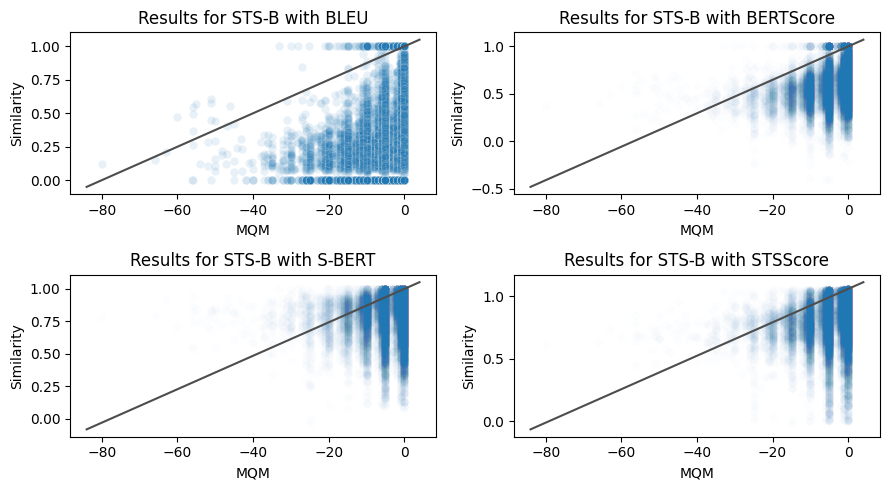

Pearson correlation


label           1.000000
bleu            0.139395
bertscore_f1    0.323568
sts_score       0.270446
sbertcosine     0.188937
Name: label, dtype: float64

Spearman correlation


label           1.000000
bleu            0.129205
bertscore_f1    0.366132
sts_score       0.341491
sbertcosine     0.243235
Name: label, dtype: float64

In [11]:
scores_wmt22 = pd.read_csv('scores/wmt22.csv')

fig, axes = plt.subplots(2, 2, figsize=(9, 5))
sns.scatterplot(x="label", y="bleu", data=scores_wmt22, alpha=0.1, ax=axes[0,0])
sns.scatterplot(x="label", y="bertscore_f1", data=scores_wmt22, alpha=0.01, ax=axes[0,1])
sns.scatterplot(x="label", y="sbertcosine", data=scores_wmt22, alpha=0.01, ax=axes[1,0])
sns.scatterplot(x="label", y="sts_score", data=scores_wmt22, alpha=0.01, ax=axes[1,1])
draw_diagonal(axes[0,0])
draw_diagonal(axes[0,1])
draw_diagonal(axes[1,0])
draw_diagonal(axes[1,1])
axes[0,0].set_ylabel("Similarity")
axes[0,1].set_ylabel("Similarity")
axes[1,0].set_ylabel("Similarity")
axes[1,1].set_ylabel("Similarity")
axes[0,0].set_xlabel("MQM")
axes[0,1].set_xlabel("MQM")
axes[1,0].set_xlabel("MQM")
axes[1,1].set_xlabel("MQM")
axes[0,0].set_title("Results for STS-B with BLEU")
axes[0,1].set_title("Results for STS-B with BERTScore")
axes[1,0].set_title("Results for STS-B with S-BERT")
axes[1,1].set_title("Results for STS-B with STSScore")

fig.tight_layout()
plt.savefig('plots/wmt22.pdf', bbox_inches='tight')
plt.savefig('plots/wmt22.png', bbox_inches='tight')
plt.show()

print('Pearson correlation')
display(scores_wmt22[['label', 'bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']].corr(method='pearson')['label'])
print('Spearman correlation')
display(scores_wmt22[['label', 'bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']].corr(method='spearman')['label'])

# Abblations

In [12]:
# prepare data for ablations
data = load_dataset('glue', 'stsb')['test']

scores_stsb = pd.read_csv('scores/stsb.csv')
scores_stsb['sentence1'] = ''
scores_stsb['sentence2'] = ''

for i, instance in enumerate(data):
    scores_stsb.iloc[i,scores_stsb.columns.get_loc('sentence1')] = instance['sentence1']
    scores_stsb.iloc[i,scores_stsb.columns.get_loc('sentence2')] = instance['sentence2']

scores_stsb['len_sentence1'] = scores_stsb['sentence1'].str.len()
scores_stsb['len_sentence2'] = scores_stsb['sentence2'].str.len()
scores_stsb['shorter_sentence'] = scores_stsb['len_sentence1'] < scores_stsb['len_sentence1'].median()

Generating test split: 100%|██████████████████████████████████████████████████████████████████████████| 1379/1379 [00:00<00:00, 57298.55 examples/s]


In [13]:
data = load_dataset('glue', 'mrpc')['test']

scores_mrpc = pd.read_csv('scores/mrpc.csv')
scores_mrpc['sentence1'] = ''
scores_mrpc['sentence2'] = ''

for i, instance in enumerate(data):
    scores_mrpc.iloc[i,scores_mrpc.columns.get_loc('sentence1')] = instance['sentence1']
    scores_mrpc.iloc[i,scores_mrpc.columns.get_loc('sentence2')] = instance['sentence2']

scores_mrpc['len_sentence1'] = scores_mrpc['sentence1'].str.len()
scores_mrpc['len_sentence2'] = scores_mrpc['sentence2'].str.len()
scores_mrpc['shorter_sentence'] = scores_mrpc['len_sentence1'] < scores_mrpc['len_sentence1'].median()

In [14]:
data = load_dataset('glue', 'qqp')['train']

scores_qqp = pd.read_csv('scores/qqp.csv')
scores_qqp['sentence1'] = ''
scores_qqp['sentence2'] = ''

for i, instance in enumerate(data):
    scores_qqp.iloc[i,scores_qqp.columns.get_loc('sentence1')] = instance['question1']
    scores_qqp.iloc[i,scores_qqp.columns.get_loc('sentence2')] = instance['question2']

scores_qqp['len_sentence1'] = scores_qqp['sentence1'].str.len()
scores_qqp['len_sentence2'] = scores_qqp['sentence2'].str.len()
scores_qqp['shorter_sentence'] = scores_qqp['len_sentence1'] < scores_qqp['len_sentence1'].median()

In [15]:
wmt22_df = pd.read_csv('data/wmt22/wmt22.csv')
scores_wmt22 = pd.read_csv('scores/wmt22.csv')

scores_wmt22['sentence1'] = wmt22_df['reference']
scores_wmt22['sentence2'] = wmt22_df['translation']

scores_wmt22['len_sentence1'] = scores_wmt22['sentence1'].str.len()
scores_wmt22['len_sentence2'] = scores_wmt22['sentence2'].str.len()
scores_wmt22['shorter_sentence'] = scores_wmt22['len_sentence1'] < scores_wmt22['len_sentence1'].median()


## Impact of sequence length

### STS-B

In [16]:
print('Pearson correlation')
print('shorter')
display(scores_stsb[scores_stsb['shorter_sentence']].corr(method='pearson', numeric_only=True)['label'][['bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']])
print('longer')
display(scores_stsb[~scores_stsb['shorter_sentence']].corr(method='pearson', numeric_only=True)['label'][['bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']])
print('Spearman correlation')
print('shorter')
display(scores_stsb[scores_stsb['shorter_sentence']].corr(method='spearman', numeric_only=True)['label'][['bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']])
print('longer')
display(scores_stsb[~scores_stsb['shorter_sentence']].corr(method='spearman', numeric_only=True)['label'][['bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']])

Pearson correlation
shorter


bleu            0.332013
bertscore_f1    0.504748
sts_score       0.901925
sbertcosine     0.838690
Name: label, dtype: float64

longer


bleu            0.334857
bertscore_f1    0.616615
sts_score       0.887822
sbertcosine     0.810901
Name: label, dtype: float64

Spearman correlation
shorter


bleu            0.326223
bertscore_f1    0.520538
sts_score       0.900200
sbertcosine     0.844550
Name: label, dtype: float64

longer


bleu            0.321199
bertscore_f1    0.606111
sts_score       0.875796
sbertcosine     0.789529
Name: label, dtype: float64

### MRPC

In [17]:
print('Mean')
display(scores_mrpc.groupby(['shorter_sentence', 'label']).mean(numeric_only=True))
print('Standard deviation')
display(scores_mrpc.groupby(['shorter_sentence', 'label']).std(numeric_only=True))

Mean


Unnamed: 0  bertscore_precision  bertscore_recall  \
shorter_sentence label                                                      
False            0      903.537383             0.586796          0.628367   
                 1      861.164653             0.708135          0.732536   
True             0      878.021978             0.505111          0.472540   
                 1      832.787629             0.651816          0.614254   

                        bertscore_f1      bleu  sts_score  sbertcosine  \
shorter_sentence label                                                   
False            0          0.607205  0.370099   0.680255     0.771491   
                 1          0.720148  0.465542   0.862620     0.856408   
True             0          0.488764  0.195785   0.569072     0.672694   
                 1          0.632737  0.292216   0.802868     0.788852   

                        len_sentence1  len_sentence2  
shorter_sentence label                                
False            0         144.714953     131.733645  
                 1         145.959215     140.655589  
True             0          88.582418      96.717033  
                 1          90.876289      97.678351

Standard deviation


Unnamed: 0  bertscore_precision  bertscore_recall  \
shorter_sentence label                                                      
False            0      519.584373             0.148675          0.151197   
                 1      494.456607             0.135245          0.116138   
True             0      496.988174             0.158515          0.144167   
                 1      493.971185             0.146725          0.140292   

                        bertscore_f1      bleu  sts_score  sbertcosine  \
shorter_sentence label                                                   
False            0          0.131069  0.160737   0.153262     0.140849   
                 1          0.111611  0.179654   0.122428     0.102224   
True             0          0.135236  0.178888   0.182026     0.141548   
                 1          0.126543  0.206947   0.143134     0.121098   

                        len_sentence1  len_sentence2  
shorter_sentence label                                
False            0          22.009560      31.655112  
                 1          20.132913      26.481617  
True             0          16.360313      25.010844  
                 1          15.781866      24.380329

### QQP

In [18]:
print('Mean')
display(scores_qqp.groupby(['shorter_sentence', 'label']).mean(numeric_only=True))
print('Standard deviation')
display(scores_qqp.groupby(['shorter_sentence', 'label']).std(numeric_only=True))

Mean


Unnamed: 0  bertscore_precision  bertscore_recall  \
shorter_sentence label                                                         
False            0      181956.866503             0.367642          0.409038   
                 1      181832.710595             0.612976          0.660669   
True             0      182071.158187             0.529292          0.490722   
                 1      181741.390340             0.715941          0.682606   

                        bertscore_f1      bleu  sts_score  sbertcosine  \
shorter_sentence label                                                   
False            0          0.388272  0.119467   0.407213     0.514935   
                 1          0.636396  0.205390   0.741862     0.845686   
True             0          0.509717  0.104731   0.481517     0.618774   
                 1          0.698942  0.170177   0.777503     0.877579   

                        len_sentence1  len_sentence2  
shorter_sentence label                                
False            0          83.348520      75.878891  
                 1          73.898082      66.891551  
True             0          38.103897      49.627188  
                 1          38.344808      43.380626

Standard deviation


Unnamed: 0  bertscore_precision  bertscore_recall  \
shorter_sentence label                                                         
False            0      105099.475434             0.279496          0.278191   
                 1      105364.661280             0.191835          0.180856   
True             0      104873.545373             0.240729          0.265185   
                 1      104900.221992             0.158838          0.179159   

                        bertscore_f1      bleu  sts_score  sbertcosine  \
shorter_sentence label                                                   
False            0          0.269324  0.250960   0.226072     0.272962   
                 1          0.172549  0.261787   0.177164     0.099208   
True             0          0.242313  0.207052   0.242326     0.257239   
                 1          0.156383  0.239404   0.183548     0.091126   

                        len_sentence1  len_sentence2  
shorter_sentence label                                
False            0          30.743567      42.030943  
                 1          22.113323      25.785277  
True             0           8.819162      26.273957  
                 1           8.103940      15.293156

### WMT22-ZH-EN

In [19]:
print('Pearson correlation')
print('shorter')
display(scores_wmt22[scores_wmt22['shorter_sentence']].corr(method='pearson', numeric_only=True)['label'][['bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']])
print('longer')
display(scores_wmt22[~scores_wmt22['shorter_sentence']].corr(method='pearson', numeric_only=True)['label'][['bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']])
print('Spearman correlation')
print('shorter')
display(scores_wmt22[scores_wmt22['shorter_sentence']].corr(method='spearman', numeric_only=True)['label'][['bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']])
print('longer')
display(scores_wmt22[~scores_wmt22['shorter_sentence']].corr(method='spearman', numeric_only=True)['label'][['bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']])

Pearson correlation
shorter


bleu            0.169508
bertscore_f1    0.345398
sts_score       0.299313
sbertcosine     0.254719
Name: label, dtype: float64

longer


bleu            0.209152
bertscore_f1    0.387850
sts_score       0.406797
sbertcosine     0.305953
Name: label, dtype: float64

Spearman correlation
shorter


bleu            0.141499
bertscore_f1    0.348345
sts_score       0.307682
sbertcosine     0.266888
Name: label, dtype: float64

longer


bleu            0.246071
bertscore_f1    0.417900
sts_score       0.421074
sbertcosine     0.307199
Name: label, dtype: float64

## Using embedding based approaches as ensemble

### STS-B

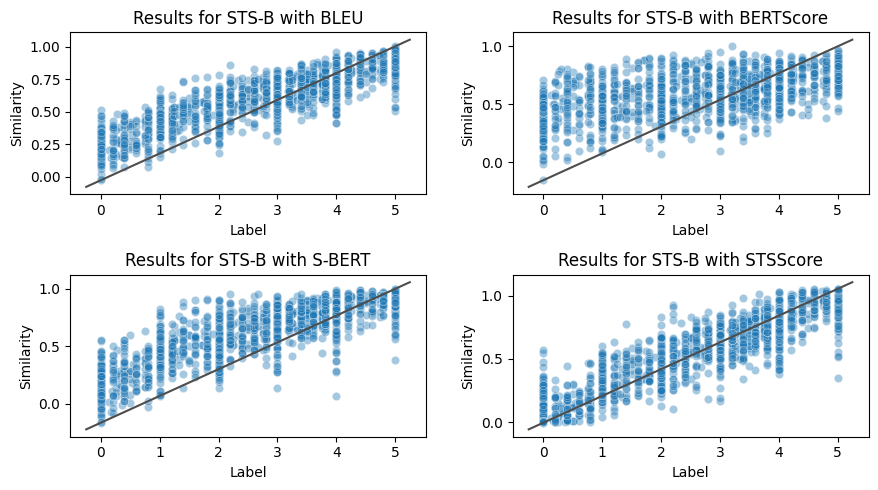

Pearson correlation


ensemble        0.877868
bertscore_f1    0.528701
sts_score       0.895954
sbertcosine     0.827406
Name: label, dtype: float64

Spearman correlation


ensemble        0.872315
bertscore_f1    0.527129
sts_score       0.889743
sbertcosine     0.820325
Name: label, dtype: float64

In [20]:
scores_stsb['ensemble'] = (scores_stsb['bertscore_f1'] + scores_stsb['sts_score'] + scores_stsb['sbertcosine'])/3

fig, axes = plt.subplots(2, 2, figsize=(9, 5))
sns.scatterplot(x="label", y="ensemble", data=scores_stsb, alpha=0.4, ax=axes[0,0])
sns.scatterplot(x="label", y="bertscore_f1", data=scores_stsb, alpha=0.4, ax=axes[0,1])
sns.scatterplot(x="label", y="sbertcosine", data=scores_stsb, alpha=0.4, ax=axes[1,0])
sns.scatterplot(x="label", y="sts_score", data=scores_stsb, alpha=0.4, ax=axes[1,1])
draw_diagonal(axes[0,0])
draw_diagonal(axes[0,1])
draw_diagonal(axes[1,0])
draw_diagonal(axes[1,1])
axes[0,0].set_ylabel("Similarity")
axes[0,1].set_ylabel("Similarity")
axes[1,0].set_ylabel("Similarity")
axes[1,1].set_ylabel("Similarity")
axes[0,0].set_xlabel("Label")
axes[0,1].set_xlabel("Label")
axes[1,0].set_xlabel("Label")
axes[1,1].set_xlabel("Label")
axes[0,0].set_title("Results for STS-B with BLEU")
axes[0,1].set_title("Results for STS-B with BERTScore")
axes[1,0].set_title("Results for STS-B with S-BERT")
axes[1,1].set_title("Results for STS-B with STSScore")

fig.tight_layout()
plt.savefig('plots/stsb_ensemble.pdf', bbox_inches='tight')
plt.savefig('plots/stsb_ensemble.png', bbox_inches='tight')
plt.show()

print('Pearson correlation')
display(scores_stsb.corr(method='pearson', numeric_only=True)['label'][['ensemble', 'bertscore_f1', 'sts_score', 'sbertcosine']])
print('Spearman correlation')
display(scores_stsb.corr(method='spearman', numeric_only=True)['label'][['ensemble', 'bertscore_f1', 'sts_score', 'sbertcosine']])

### MRPC

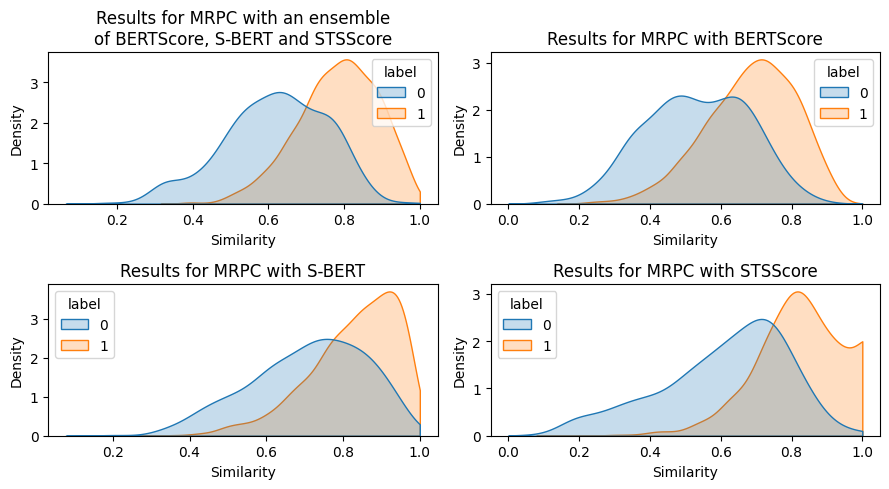

Mean


,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score,sbertcosine,len_sentence1,len_sentence2,shorter_sentence,ensemble
label,,,,,,,,,,,
0,887.468858,0.535354,0.530233,0.532616,0.260324,0.610237,0.709273,109.365052,109.681661,0.629758,0.617375
1,849.165650,0.684321,0.682521,0.683187,0.392253,0.837354,0.827843,122.667829,122.482999,0.422842,0.782795


Standard deviation


,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score,sbertcosine,len_sentence1,len_sentence2,shorter_sentence,ensemble
label,,,,,,,,,,,
0,505.174105,0.159769,0.164882,0.145341,0.191747,0.180008,0.149024,32.911255,32.401174,0.483288,0.134323
1,494.234810,0.142888,0.139676,0.125755,0.209861,0.134796,0.115480,32.864846,33.266868,0.494226,0.105787


In [21]:
scores_mrpc['ensemble'] = (scores_mrpc['bertscore_f1'] +scores_mrpc['sts_score'] + scores_mrpc['sbertcosine'])/3

fig, axes = plt.subplots(2, 2, figsize=(9, 5))
sns.kdeplot(scores_mrpc, x="ensemble", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,0])
sns.kdeplot(scores_mrpc, x="bertscore_f1", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,1])
sns.kdeplot(scores_mrpc, x="sbertcosine", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,0])
sns.kdeplot(scores_mrpc, x="sts_score", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,1])

axes[0,0].set_xlabel("Similarity")
axes[0,1].set_xlabel("Similarity")
axes[1,0].set_xlabel("Similarity")
axes[1,1].set_xlabel("Similarity")
axes[0,0].set_title("Results for MRPC with an ensemble\nof BERTScore, S-BERT and STSScore")
axes[0,1].set_title("Results for MRPC with BERTScore")
axes[1,0].set_title("Results for MRPC with S-BERT")
axes[1,1].set_title("Results for MRPC with STSScore")

sns.move_legend(axes[1,0], "upper left")
sns.move_legend(axes[1,1], "upper left")
fig.tight_layout()
plt.savefig('plots/mrpc_ensemble.pdf', bbox_inches='tight')
plt.show()
print('Mean')
display(scores_mrpc.groupby('label').mean(numeric_only=True))
print('Standard deviation')
display(scores_mrpc.groupby('label').std(numeric_only=True))

### QQP

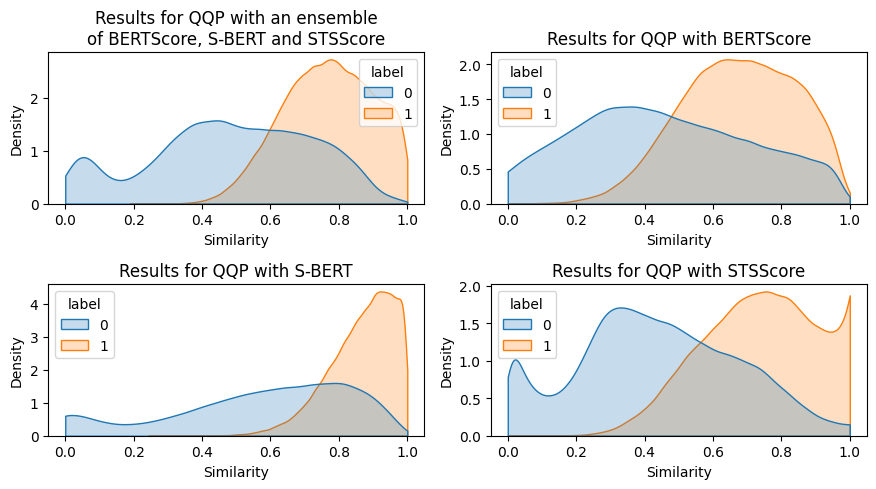

Mean


,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score,sbertcosine,len_sentence1,len_sentence2,shorter_sentence,ensemble
label,,,,,,,,,,,
0,182006.746963,0.438191,0.444688,0.441274,0.113036,0.439641,0.560253,63.602354,64.421828,0.436431,0.480390
1,181778.637299,0.673945,0.673659,0.673431,0.184540,0.762966,0.864571,52.845987,52.970070,0.592128,0.766989


Standard deviation


,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score,sbertcosine,len_sentence1,len_sentence2,shorter_sentence,ensemble
label,,,,,,,,,,,
0,105000.718917,0.275215,0.275584,0.264823,0.232932,0.236197,0.271149,32.712507,38.293303,0.495944,0.238744
1,105089.519470,0.180303,0.180175,0.166039,0.249377,0.181817,0.095797,23.315583,23.306007,0.491441,0.130740


In [22]:
scores_qqp['ensemble'] = (scores_qqp['bertscore_f1'] +scores_qqp['sts_score'] + scores_qqp['sbertcosine'])/3

fig, axes = plt.subplots(2, 2, figsize=(9, 5))
sns.kdeplot(scores_qqp, x="ensemble", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,0])
sns.kdeplot(scores_qqp, x="bertscore_f1", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,1])
sns.kdeplot(scores_qqp, x="sbertcosine", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,0])
sns.kdeplot(scores_qqp, x="sts_score", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,1])

axes[0,0].set_xlabel("Similarity")
axes[0,1].set_xlabel("Similarity")
axes[1,0].set_xlabel("Similarity")
axes[1,1].set_xlabel("Similarity")
axes[0,0].set_title("Results for QQP with an ensemble\nof BERTScore, S-BERT and STSScore")
axes[0,1].set_title("Results for QQP with BERTScore")
axes[1,0].set_title("Results for QQP with S-BERT")
axes[1,1].set_title("Results for QQP with STSScore")

sns.move_legend(axes[0,1], "upper left")
sns.move_legend(axes[1,0], "upper left")
sns.move_legend(axes[1,1], "upper left")
fig.tight_layout()
plt.savefig('plots/qqp_ensemble.pdf', bbox_inches='tight')
plt.show()
print('Mean')
display(scores_qqp.groupby('label').mean(numeric_only=True))
print('Standard deviation')
display(scores_qqp.groupby('label').std(numeric_only=True))

### WMT22-ZH-EN

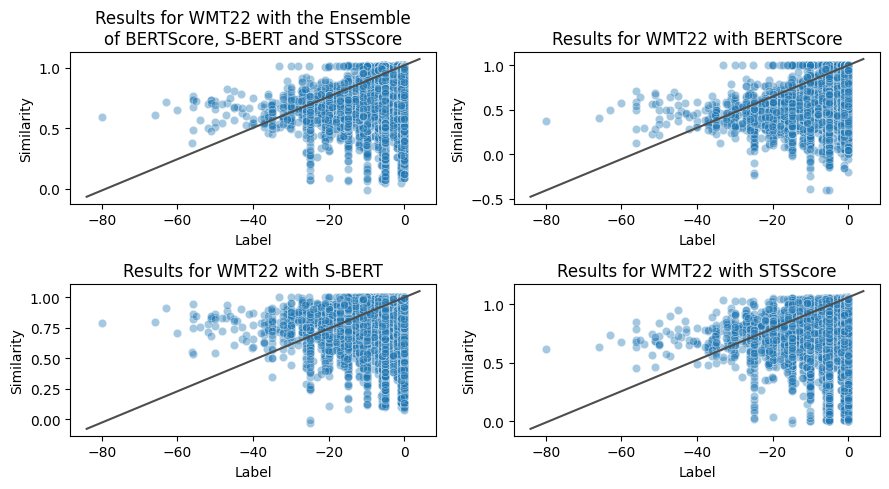

Pearson correlation


ensemble        0.297795
bertscore_f1    0.323568
sts_score       0.270446
sbertcosine     0.188937
Name: label, dtype: float64

Spearman correlation


ensemble        0.353064
bertscore_f1    0.366132
sts_score       0.341491
sbertcosine     0.243235
Name: label, dtype: float64

In [23]:
scores_wmt22['ensemble'] = (scores_wmt22['bertscore_f1'] + scores_wmt22['sts_score'] + scores_wmt22['sbertcosine'])/3

fig, axes = plt.subplots(2, 2, figsize=(9, 5))
sns.scatterplot(x="label", y="ensemble", data=scores_wmt22, alpha=0.4, ax=axes[0,0])
sns.scatterplot(x="label", y="bertscore_f1", data=scores_wmt22, alpha=0.4, ax=axes[0,1])
sns.scatterplot(x="label", y="sbertcosine", data=scores_wmt22, alpha=0.4, ax=axes[1,0])
sns.scatterplot(x="label", y="sts_score", data=scores_wmt22, alpha=0.4, ax=axes[1,1])
draw_diagonal(axes[0,0])
draw_diagonal(axes[0,1])
draw_diagonal(axes[1,0])
draw_diagonal(axes[1,1])
axes[0,0].set_ylabel("Similarity")
axes[0,1].set_ylabel("Similarity")
axes[1,0].set_ylabel("Similarity")
axes[1,1].set_ylabel("Similarity")
axes[0,0].set_xlabel("Label")
axes[0,1].set_xlabel("Label")
axes[1,0].set_xlabel("Label")
axes[1,1].set_xlabel("Label")
axes[0,0].set_title("Results for WMT22 with the Ensemble\nof BERTScore, S-BERT and STSScore")
axes[0,1].set_title("Results for WMT22 with BERTScore")
axes[1,0].set_title("Results for WMT22 with S-BERT")
axes[1,1].set_title("Results for WMT22 with STSScore")

fig.tight_layout()
plt.savefig('plots/wmt22_ensemble.pdf', bbox_inches='tight')
plt.savefig('plots/wmt22_ensemble.png', bbox_inches='tight')
plt.show()

print('Pearson correlation')
display(scores_wmt22.corr(method='pearson', numeric_only=True)['label'][['ensemble', 'bertscore_f1', 'sts_score', 'sbertcosine']])
print('Spearman correlation')
display(scores_wmt22.corr(method='spearman', numeric_only=True)['label'][['ensemble', 'bertscore_f1', 'sts_score', 'sbertcosine']])

### AUC for the ensemble

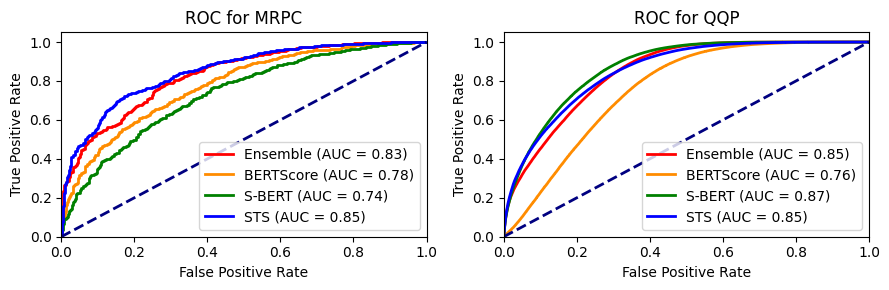

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Plot the ROC curve vor MRPC
# Compute the false positive rate, true positive rate, and thresholds
fpr_bertscore, tpr_bertscore, thresholds_bertscore = roc_curve(scores_mrpc['label'], scores_mrpc['bertscore_f1'])
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(scores_mrpc['label'], scores_mrpc['ensemble'])
fpr_sbert, tpr_sbert, thresholds_sbert = roc_curve(scores_mrpc['label'], scores_mrpc['sbertcosine'])
fpr_sts, tpr_sts, thresholds_sts = roc_curve(scores_mrpc['label'], scores_mrpc['sts_score'])

# Compute the area under the ROC curve
roc_auc_bertscore = auc(fpr_bertscore, tpr_bertscore)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)
roc_auc_sbert = auc(fpr_sbert, tpr_sbert)
roc_auc_sts = auc(fpr_sts, tpr_sts)

axes[0].plot(fpr_ensemble, tpr_ensemble, color='red', lw=2, label='Ensemble (AUC = %0.2f)' % roc_auc_ensemble)
axes[0].plot(fpr_bertscore, tpr_bertscore, color='darkorange', lw=2, label='BERTScore (AUC = %0.2f)' % roc_auc_bertscore)
axes[0].plot(fpr_sbert, tpr_sbert, color='green', lw=2, label='S-BERT (AUC = %0.2f)' % roc_auc_sbert)
axes[0].plot(fpr_sts, tpr_sts, color='blue', lw=2, label='STS (AUC = %0.2f)' % roc_auc_sts)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC for MRPC')
axes[0].legend(loc="lower right")

# Plot the ROC curve for qqp
# Compute the false positive rate, true positive rate, and thresholds
fpr_bertscore, tpr_bertscore, thresholds_bertscore = roc_curve(scores_qqp['label'], scores_qqp['bertscore_f1'])
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(scores_qqp['label'], scores_qqp['ensemble'])
fpr_sbert, tpr_sbert, thresholds_sbert = roc_curve(scores_qqp['label'], scores_qqp['sbertcosine'])
fpr_sts, tpr_sts, thresholds_sts = roc_curve(scores_qqp['label'], scores_qqp['sts_score'])

# Compute the area under the ROC curve
roc_auc_bertscore = auc(fpr_bertscore, tpr_bertscore)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)
roc_auc_sbert = auc(fpr_sbert, tpr_sbert)
roc_auc_sts = auc(fpr_sts, tpr_sts)

# Plot the ROC curve
axes[1].plot(fpr_ensemble, tpr_ensemble, color='red', lw=2, label='Ensemble (AUC = %0.2f)' % roc_auc_ensemble)
axes[1].plot(fpr_bertscore, tpr_bertscore, color='darkorange', lw=2, label='BERTScore (AUC = %0.2f)' % roc_auc_bertscore)
axes[1].plot(fpr_sbert, tpr_sbert, color='green', lw=2, label='S-BERT (AUC = %0.2f)' % roc_auc_sbert)
axes[1].plot(fpr_sts, tpr_sts, color='blue', lw=2, label='STS (AUC = %0.2f)' % roc_auc_sts)
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC for QQP')
axes[1].legend(loc="lower right")
fig.tight_layout()
plt.savefig('plots/auc_ensemble.pdf', bbox_inches='tight')
plt.show()